In [12]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data exploration libraries
from requests import get
from io import StringIO
from ydata_profiling import ProfileReport
from IPython.display import HTML

# ML libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score

In [13]:
url = "https://storage.googleapis.com/the_public_bucket/wine-clustering.csv" # Direct link to the dataset
response = get(url)

if response.status_code == 200:
    data = pd.read_csv(StringIO(response.text)) # Dataframe from the csv file
    print('Data retrieved successfully')
else:
    print(f"Failed to download dataset. Status code: {response.status_code}")

data.head(2)
print(data.shape)

Data retrieved successfully
(178, 13)


# Clustering analysis tests

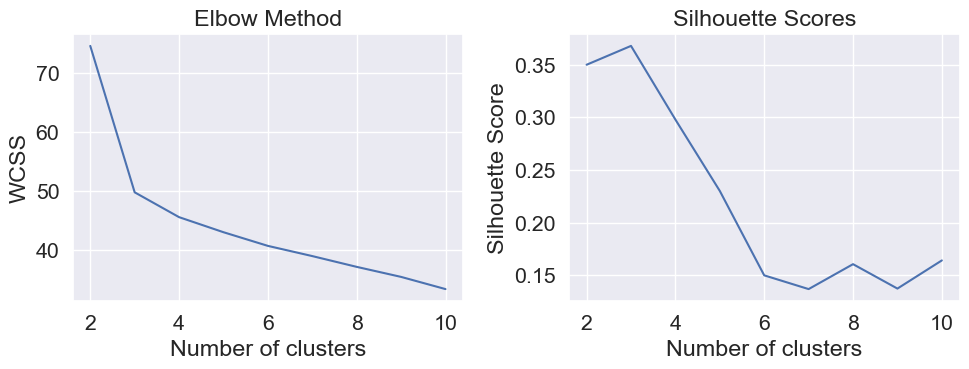

In [37]:
from sklearn.preprocessing import MinMaxScaler

# Data scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

wcss = [] #within-cluster sum of squares
silhouette_scores = []
max_clusters = 10

for i in range(2, max_clusters+1):
    # Initialize a KMeans object with i clusters, using the k-means++ initialization method,
    # a maximum of 300 iterations for a single run, and 10 runs with different centroid seeds
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=15, random_state=42)
    
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the WCSS values for each number of clusters
axs[0].plot(range(2, max_clusters+1), wcss)
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('WCSS')

# Plot the silhouette scores for each number of clusters
axs[1].plot(range(2, max_clusters+1), silhouette_scores)
axs[1].set_title('Silhouette Scores')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [28]:
optimal_clusters = np.argmax(silhouette_scores) + 2
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(data_scaled)

In [32]:
np.argmax(silhouette_scores) + 2

3

In [17]:
data['Cluster'] = pred_y
data.groupby('Cluster').mean()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
Cluster,,,,,,,,,,,,,
0,13.636349,1.939841,2.452222,17.388889,109.380952,2.823016,2.962698,0.290952,1.951587,5.398254,1.071270,3.150952,1089.634921
1,12.281667,1.966364,2.234091,20.062121,91.075758,2.249242,2.052424,0.363485,1.564242,3.036818,1.050394,2.781061,508.333333
2,13.151633,3.344490,2.434694,21.438776,99.020408,1.678163,0.797959,0.450816,1.163061,7.343265,0.685918,1.690204,627.551020


Model evaluation

In [18]:
X = data.drop('Cluster', axis=1)
y = data['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [20]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

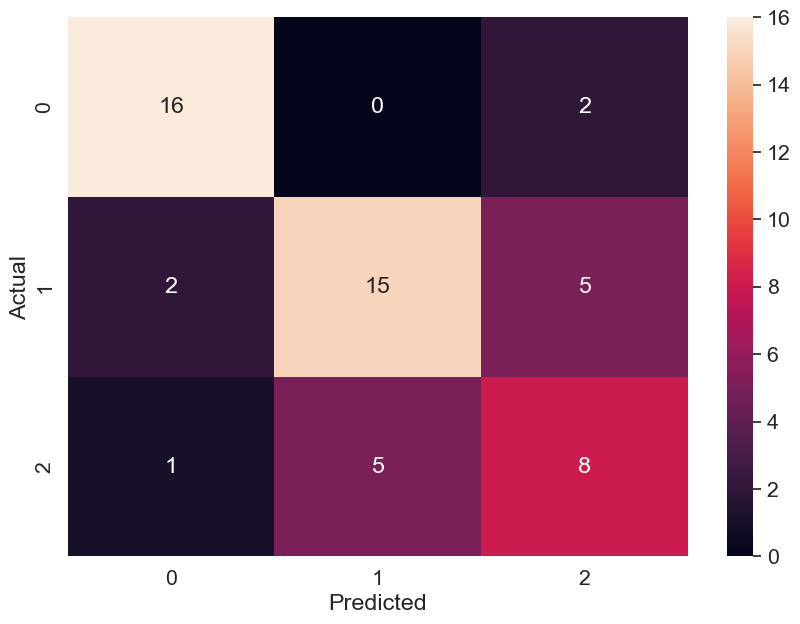

In [21]:
y_pred = knn.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'

plt.figure(figsize = (10,7))

sns.set(font_scale=1.4) # For label size
sns.heatmap(cm_df,annot=True) # font size

plt.show()

In [22]:
sns.pairplot(data, hue='Cluster', diag_kind='kde')